# Deep Emulator: a Multi-Layer Perceptron

We use preprocessed data from tunax simulations of the Kato-Phillips case to train a basic neural network. From five channels of input as represented below, it learns to predict the state of the temperature residual column at time t+1 ($\Delta T$).

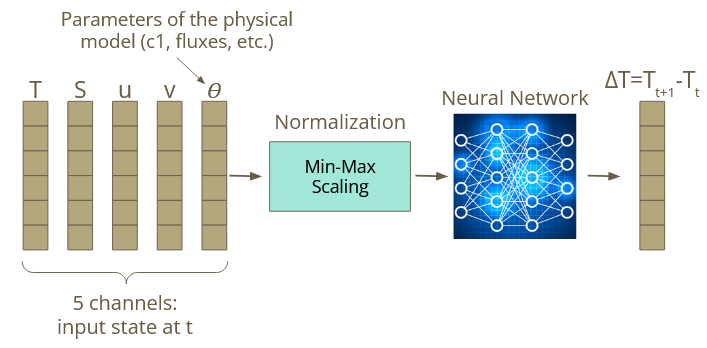

In [17]:
from PIL import Image

image = Image.open('data_process.PNG')
image.show()

The notebook is structuted as follows:
1. Imports
2. Data Loading
3. Initialization of the Multi-Layer Perceptron
4. Training
5. Visualization (Loss)

### 1. Imports

In [10]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random, vmap
from jax.example_libraries import optimizers
import numpy as np
import matplotlib.pyplot as plt
import pickle

### 2. Data Loading

In [11]:
train_data = np.load("train_data.npy")
train_labels = np.load("train_labels.npy")
test_data = np.load("test_data.npy")
test_labels = np.load("test_labels.npy")

# Convert to jax
train_data = jnp.array(train_data)
train_labels = jnp.array(train_labels)
test_data = jnp.array(test_data)
test_labels = jnp.array(test_labels)

### 3. Initialization of the Multi-Layer Perceptron

In [20]:
def init_mlp_params(layer_sizes, key):
    keys = random.split(key, len(layer_sizes) - 1)
    params = []
    for m, n, k in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        weight = random.normal(k, (m, n)) * jnp.sqrt(2.0 / m)
        bias = jnp.zeros(n)
        params.append((weight, bias))
    return params

def mlp(params, x):
    for w, b in params[:-1]:
        x = jnp.tanh(jnp.dot(x, w) + b)
    w_last, b_last = params[-1]
    return jnp.dot(x, w_last) + b_last

In [ ]:
# Initialize MLP parameters
layer_sizes = [train_data.shape[1], 64, 64, 1]  # 5 -> 64 -> 64 -> 1
key = random.PRNGKey(0)
params = init_mlp_params(layer_sizes, key)

In [13]:
# Loss function
def loss_fn(params, x, y):
    predictions = mlp(params, x)
    return jnp.mean((predictions - y) ** 2) # MSE

# Optimizer
opt_init, opt_update, get_params = optimizers.adam(5e-4)
opt_state = opt_init(params)

# Accelerate loss with jit
loss_fn_jit = jit(loss_fn)

@jit
def update(step, opt_state, x, y):
    params = get_params(opt_state)
    gradients = grad(loss_fn)(params, x, y)
    return opt_update(step, gradients, opt_state)

### 4. Training

In [14]:
num_epochs = 20
batch_size = 64
num_batches = train_data.shape[0] // batch_size

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    perm = random.permutation(key, train_data.shape[0])  # Shuffle indices
    train_data = train_data[perm]
    train_labels = train_labels[perm]

    assert not jnp.isnan(train_data).any(), "NaN in train_data"
    assert not jnp.isnan(train_labels).any(), "NaN in train_labels"

    for i in range(num_batches):
        batch_x = train_data[i * batch_size:(i + 1) * batch_size]
        batch_y = train_labels[i * batch_size:(i + 1) * batch_size]
        opt_state = update(epoch * num_batches + i, opt_state, batch_x, batch_y)

    # Track losses
    params = get_params(opt_state)
    train_loss = loss_fn_jit(params, train_data, train_labels)
    test_loss = loss_fn_jit(params, test_data, test_labels)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Save model parameters in .pth (cf. pytorch)
params = get_params(opt_state)
with open("mlp_model.pth", "wb") as f:
    pickle.dump(params, f)
print("Saved as 'mlp_model.pth'.")

Epoch 0, Train Loss: 0.1811, Test Loss: 0.1764
Epoch 10, Train Loss: 0.0099, Test Loss: 0.0135
Saved as 'mlp_model.pth'.


### 5. Visualization

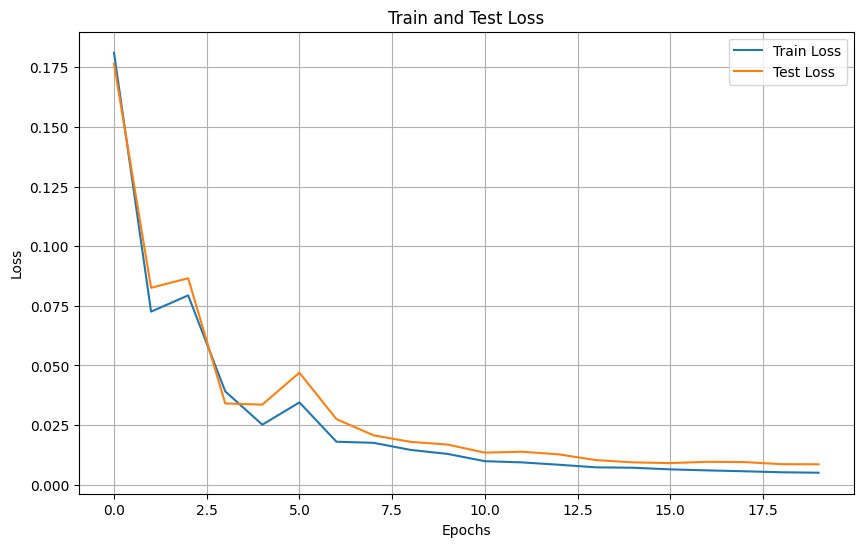

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Loss")
plt.legend()
plt.grid(True)
plt.savefig("loss_plot.png")  # Save figure
plt.show()

# Load model from .pth file
def load_model(file_path):
    with open(file_path, "rb") as f:
        params = pickle.load(f)
    return params

# Load model
loaded_params = load_model("mlp_model.pth")

# Prediction for test set
test_predictions = vmap(lambda x: mlp(loaded_params, x))(test_data)

In [ ]:
# MLP cleaner version

import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn

class MLP(nn.Module):
    hidden_sizes: list  # Liste des tailles des couches cachées

    @nn.compact
    def __call__(self, x):
        for size in self.hidden_sizes:
            x = nn.Dense(size)(x)
            x = nn.relu(x)
        x = nn.Dense(1)(x)  # Dernière couche pour réduire à 1 channel
        return x

# Initialisation des paramètres
key = random.PRNGKey(0)

# Dimensions des données d'entrée
n = 10  # Nombre de lignes (exemple)
input_channels = 5  # Nombre de colonnes

# Données d'entrée aléatoires
x = random.normal(key, (n, input_channels))

# Création du modèle
hidden_sizes = [64, 32, 16]  # Exemple de tailles des couches cachées
mlp = MLP(hidden_sizes=hidden_sizes)

# Initialisation des poids du modèle
params = mlp.init(key, x)

# Exécution du modèle sur les données d'entrée
output = mlp.apply(params, x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)